# Install, Upgrade & Import necessary libraries 

In [1]:
%%capture
!pip install stopwords
!pip install --upgrade smart_open
!pip install --upgrade botocore
!pip install demoji
!pip install nltk
!pip install swifter
!pip install flair
!pip install --upgrade smart_open
!pip install --upgrade botocore
!pip install demoji

In [2]:
import pandas as pd
import numpy as np
# import flair
# from flair.data import Sentence
import re
import nltk.data
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand
import demoji
pd.options.display.max_rows = None
import warnings
warnings.filterwarnings('ignore')

# Import Amazon Product Reviews Dataset

In [3]:
df = pd.read_csv('../input/amazon-product-reviews/Reviews.csv')
df.head() 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Preprocessing

In [4]:
df.shape

(568454, 10)

In [5]:
df = df[['Score','Text','Summary']]

In [6]:
df.isnull().sum()

Score       0
Text        0
Summary    27
dtype: int64

In [7]:
df.dropna(axis=0,inplace=True)
df.isnull().sum()

Score      0
Text       0
Summary    0
dtype: int64

In [8]:
df.duplicated().sum()

173424

In [9]:
# Remove duplicated values
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [10]:
df.Score.value_counts()

Score
5    251604
4     56207
1     36505
3     29842
2     20845
Name: count, dtype: int64

The data distribution in the Score column seems to be imbalanced, but this can be solved by using the f1-score metrics to evaluate our model later.

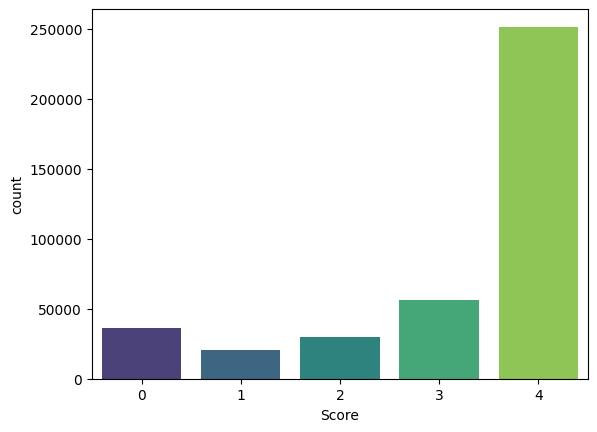

In [11]:
sns.countplot(x='Score', data=df, palette='viridis')
plt.xticks([0, 1, 2, 3, 4], ['0', '1', '2', '3', '4'])

plt.show()

# Data Cleaning

### In the cleaning process, i will remove symbols, urls, numbers, emojis, extra whitespaces, and punctuations. Then, the texts will be tokenized and stemmed.

In [12]:
def clean(text):
    text = re.sub("[^A-Za-z]"," ",text)
    
    return text

In [13]:
def remove_num(text):
   text = re.sub(r'\d+', '', text)
   return text

In [14]:
def remove_emoji(text):
    return demoji.replace(text, repl="")

In [15]:
def remove_extra_ws(text):
    text = re.sub(' +', ' ', text)
    return text

In [16]:
def remove_punctuation(text):
    text = "".join(i for i in text if i not in (".",";",":","?","!",'"',','))
    return text

In [17]:
def tokenize(text):
    text = nltk.word_tokenize(text)
    
    return text

In [18]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer

In [20]:
stopwords = set(stopwords.words("english"))
porter_stemmer = PorterStemmer()
wn_lemma = WordNetLemmatizer()

In [21]:
def remove_stopword(text):
   text = [i.lower() for i in text.split() if i.lower() not in stopwords]
   return " ".join(text)

In [22]:
def stemming(text):
   result = []
   stemmed_word = [porter_stemmer.stem(i) for i in text]
   result = ' '.join(stemmed_word)
   return result

In [23]:
def deep_clean(df,column):
    df[column] = df[column].str.lower()
    df[column] = df[column].apply(clean)
    df[column] = df[column].apply(remove_num)
    df[column] = df[column].apply(remove_emoji)
    df[column] = df[column].apply(remove_extra_ws)
    df[column] = df[column].apply(remove_punctuation)
    df[column] = df[column].apply(remove_stopword)
    df[column] = df[column].apply(tokenize)
    df[column] = df[column].map(stemming)

In [24]:
df_copy = df

In [25]:
# deep_clean(df_copy,'Text')
# deep_clean(df_copy,'Summary')

In [26]:
# Export to csv to save time on cleaning process
# df_copy.to_csv('amazon_review_cleaned.csv',index=False)

In [27]:
# df_copy = pd.read_csv('/kaggle/input/cleaned/amazon_review_cleaned.csv')

In [28]:
train = df_copy.sample(frac=0.8, random_state=42)
test = df_copy.drop(train.index)

In [29]:
train.shape

(316002, 3)

In [30]:
test.shape

(79001, 3)

In [31]:
# Split Train and Test set to X_train, X_test, y_train, and y_test
X_train = train['Text']
y_train = train['Score']

X_test = test['Text']
y_test = test['Score']

In [32]:
# Tokenizing to sequences, and padding the train and test set
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length
max_len = max(len(seq) for seq in X_train_sequences + X_test_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')

In [ ]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=X_train.apply(word_tokenize), vector_size=100, window=5, min_count=1, workers=4)

# Embedding matrix for the Embedding layer in the BiLSTM model
embedding_matrix = word2vec_model.wv.vectors

#### Build a baseline model

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D
import tensorflow as tf

In [ ]:
input_dim = len(tokenizer.word_index) + 1  # +1 to include the padding token
embedding_dim = embedding_matrix.shape[1]

# Initialize the corrected embedding matrix with zeros
embedding_matrix_corrected = np.zeros((input_dim, embedding_dim))

# Fill the corrected embedding matrix with the existing embeddings
for word, i in tokenizer.word_index.items():
    if i < embedding_matrix.shape[0]:
        embedding_matrix_corrected[i] = embedding_matrix[i]

# Now you can use the corrected embedding matrix
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=embedding_dim, weights=[embedding_matrix_corrected], trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(3, activation='softmax'))  # 3 classes, so the output dimension is 3

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the BiLSTM model
model.fit(X_train_padded, y_train, epochs=6, batch_size=128, validation_split=0.2)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
image_path = '//kaggle/input/model-images/model_bilstm_trained.JPG'  

# Load and display the image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')  
plt.show()

#### Result of the model after training.

# Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Use the trained model to predict on the test set
y_pred = model.predict(X_test_padded)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate a classification report
report = classification_report(y_test, y_pred_labels)

# Print the classification report
print(report)

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_labels, average='weighted')  # For binary classification
print(f'F1 Score: {f1}')